# dataset

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.0
torchvision version: 0.13.0


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Setup path to data folder
# C:\Users\Saeth\Downloads\archive (1)\Data
data_path = "C:\\Users\\Saeth\\Downloads\\archive (1)\\"
image_path = data_path + "Data\\"
# Setup Dirs
train_dir = image_path + "train"
test_dir = image_path + "test"

In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [6]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()
#NUM_WORKERS = 0
# NUM_WORKERS = 8

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

# train with early stopping and learning rate scheduling

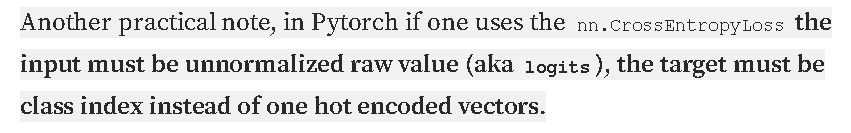

In [7]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import timeit

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device) # y shape = [batch]

        # 1. Forward pass
        y_pred = model(X) # shape = [batch, class]

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.softmax(test_pred_logits, dim=1).argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    
    # track accuracy (if it doesn't increase, reducr the learning rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=1, verbose=True)
    
    early_stop_count=0
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        start = timeit.default_timer()
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        stop = timeit.default_timer()

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"learning rate: {scheduler.optimizer.param_groups[0]['lr']:.6f} | "
          f"time (sec): {stop-start:.2f}"
        )
        
        scheduler.step(test_acc) # monitor test accuracy
        
        # early stopping
        if epoch==0:
            pass
        else:
            if test_acc - results["test_acc"][-1] <= 0.005:
                early_stop_count+=1
                if early_stop_count==2:
                    print('early stopping!')
                    break
            else:
                early_stop_count=0
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
                
    # Return the filled results at the end of the epochs
    return results

In [8]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    print('average train accuracy:', sum(accuracy)/len(accuracy))
    print('average test accuracy:', sum(test_accuracy)/len(test_accuracy))

In [9]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
def plot_confision_matrix(model):
    # 1. Make predictions with trained model
    y_preds = []
    y_trues = []
    model.eval()
    with torch.inference_mode():
      for batch, (X, y) in tqdm(enumerate(test_dataloader), desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit.squeeze(), dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_trues.append(y.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    y_true_tensor = torch.cat(y_trues)
    
    # 2. Setup confusion matrix instance and compare predictions to targets
    confmat = ConfusionMatrix(num_classes=len(class_names))
    confmat_tensor = confmat(preds=y_pred_tensor,
                             target=y_true_tensor)

    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
        class_names=class_names, # turn the row and column labels into class names
        figsize=(10, 7)
    );

# resnet50

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet50_Weights.IMAGENET1K_V2

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f1d827eb50>,
 ['COVID19', 'NORMAL', 'PNEUMONIA'])

In [14]:
for batch, (X, y) in enumerate(test_dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    print(y)
    print(y.shape)
    break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
torch.Size([32])


In [13]:
model = torchvision.models.resnet50(weights=weights).to(device)

In [14]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
ResNet (ResNet)                          [32, 3, 224, 224] [32, 1000]      --              True
├─Conv2d (conv1)                         [32, 3, 224, 224] [32, 64, 112, 112] 9,408           True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112] [32, 64, 112, 112] 128             True
├─ReLU (relu)                            [32, 64, 112, 112] [32, 64, 112, 112] --              --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112] [32, 64, 56, 56] --              --
├─Sequential (layer1)                    [32, 64, 56, 56] [32, 256, 56, 56] --              True
│    └─Bottleneck (0)                    [32, 64, 56, 56] [32, 256, 56, 56] --              True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56] [32, 64, 56, 56] 4,096           True
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56] [32, 64, 56, 56] 128             True
│    │    └─ReLU (relu)   

In [15]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [16]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [17]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
ResNet (ResNet)                          [32, 3, 224, 224] [32, 3]         --              Partial
├─Conv2d (conv1)                         [32, 3, 224, 224] [32, 64, 112, 112] (9,408)         False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112] [32, 64, 112, 112] (128)           False
├─ReLU (relu)                            [32, 64, 112, 112] [32, 64, 112, 112] --              --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112] [32, 64, 56, 56] --              --
├─Sequential (layer1)                    [32, 64, 56, 56] [32, 256, 56, 56] --              False
│    └─Bottleneck (0)                    [32, 64, 56, 56] [32, 256, 56, 56] --              False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56] [32, 64, 56, 56] (4,096)         False
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56] [32, 64, 56, 56] (128)           False
│    │    └─ReLU 

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
set_seeds()
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3712 | train_acc: 0.8736 | test_loss: 1.6564 | test_acc: 0.8483 | learning rate: 0.100000 | time (sec): 70.73
Epoch: 2 | train_loss: 0.9814 | train_acc: 0.9112 | test_loss: 1.5963 | test_acc: 0.8765 | learning rate: 0.100000 | time (sec): 66.07
Epoch: 3 | train_loss: 0.9495 | train_acc: 0.9244 | test_loss: 1.1152 | test_acc: 0.9192 | learning rate: 0.100000 | time (sec): 66.20
Epoch: 4 | train_loss: 1.3111 | train_acc: 0.9227 | test_loss: 2.1253 | test_acc: 0.8948 | learning rate: 0.100000 | time (sec): 67.02
Epoch: 5 | train_loss: 1.2876 | train_acc: 0.9293 | test_loss: 1.7774 | test_acc: 0.9139 | learning rate: 0.100000 | time (sec): 67.17
Epoch 00005: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 6 | train_loss: 0.7214 | train_acc: 0.9563 | test_loss: 2.3413 | test_acc: 0.8963 | learning rate: 0.010000 | time (sec): 66.81
Epoch: 7 | train_loss: 0.7043 | train_acc: 0.9512 | test_loss: 2.4891 | test_acc: 0.8941 | learning rate: 0.010000 | time (sec):

average train accuracy: 0.9195781573498966
average test accuracy: 0.8915142276422764


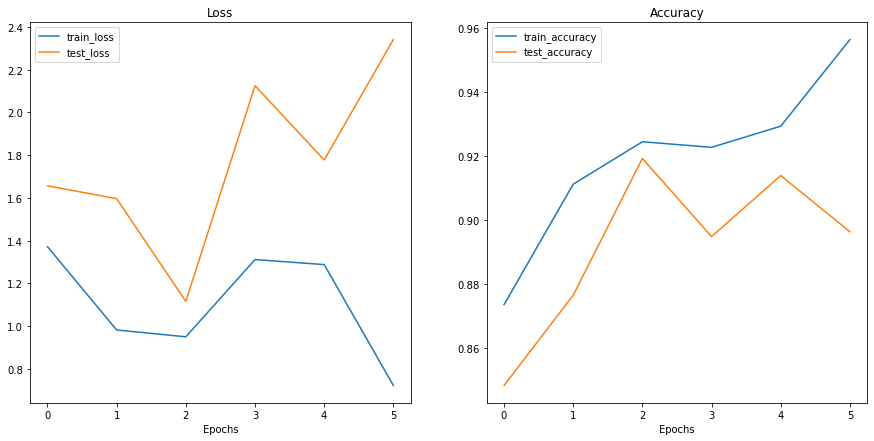

In [19]:
# Plot the loss curves of our model
plot_loss_curves(results)

Making predictions: 0it [00:00, ?it/s]

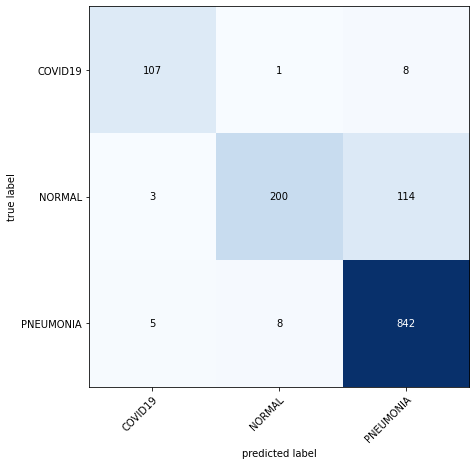

In [20]:
plot_confision_matrix(model)

# vgg16

In [21]:
# Get a set of pretrained model weights
weights = torchvision.models.VGG16_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

VGG16_Weights.IMAGENET1K_V1

In [22]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [23]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1aa1739ee80>,
 ['COVID19', 'NORMAL', 'PNEUMONIA'])

In [24]:
model = torchvision.models.vgg16(weights=weights).to(device)

In [25]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
VGG (VGG)                                [32, 3, 224, 224] [32, 1000]      --              True
├─Sequential (features)                  [32, 3, 224, 224] [32, 512, 7, 7] --              True
│    └─Conv2d (0)                        [32, 3, 224, 224] [32, 64, 224, 224] 1,792           True
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] 36,928          True
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --              --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] 73,856          True
│    └─ReLU (6)                          [32, 128, 112, 112] [32, 128, 112, 112] --              --
│    └─Conv2d (

In [26]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [27]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [28]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier[6] =  torch.nn.Linear(in_features=4096, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True).to(device)

In [29]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
VGG (VGG)                                [32, 3, 224, 224] [32, 3]         --              Partial
├─Sequential (features)                  [32, 3, 224, 224] [32, 512, 7, 7] --              False
│    └─Conv2d (0)                        [32, 3, 224, 224] [32, 64, 224, 224] (1,792)         False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)        False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --              --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)        False
│    └─ReLU (6)                          [32, 128, 112, 112] [32, 128, 112, 112] --              --
│    └─C

In [30]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
set_seeds()
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.4215 | train_acc: 0.8277 | test_loss: 3.7715 | test_acc: 0.9070 | learning rate: 0.100000 | time (sec): 94.68
Epoch: 2 | train_loss: 7.1870 | train_acc: 0.8599 | test_loss: 3.1786 | test_acc: 0.9284 | learning rate: 0.100000 | time (sec): 93.52
Epoch: 3 | train_loss: 7.1105 | train_acc: 0.8755 | test_loss: 3.1454 | test_acc: 0.9207 | learning rate: 0.100000 | time (sec): 92.32
Epoch: 4 | train_loss: 7.7365 | train_acc: 0.8747 | test_loss: 6.8094 | test_acc: 0.8765 | learning rate: 0.100000 | time (sec): 92.73
Epoch 00004: reducing learning rate of group 0 to 1.0000e-02.
early stopping!


average train accuracy: 0.854339199447895
average test accuracy: 0.91869918699187


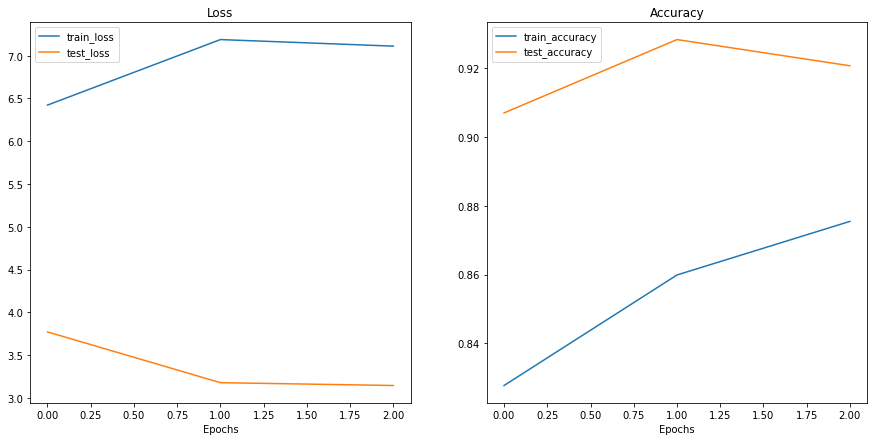

In [31]:
# Plot the loss curves of our model
plot_loss_curves(results)

Making predictions: 0it [00:00, ?it/s]

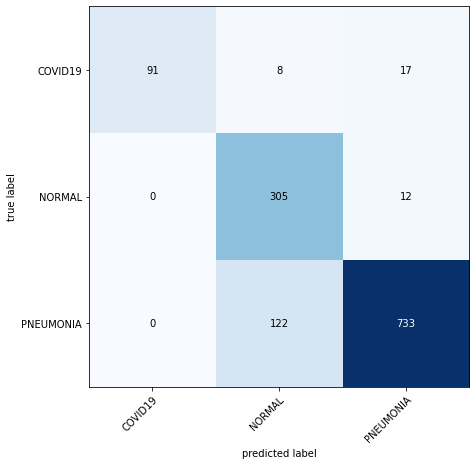

In [32]:
plot_confision_matrix(model)

# fine-tune the top layer

In [33]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [34]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
VGG (VGG)                                [32, 3, 224, 224] [32, 3]         --              False
├─Sequential (features)                  [32, 3, 224, 224] [32, 512, 7, 7] --              False
│    └─Conv2d (0)                        [32, 3, 224, 224] [32, 64, 224, 224] (1,792)         False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)        False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --              --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)        False
│    └─ReLU (6)                          [32, 128, 112, 112] [32, 128, 112, 112] --              --
│    └─Con

In [35]:
model.classifier[3]

Linear(in_features=4096, out_features=4096, bias=True)

In [36]:
for param in model.classifier[3].parameters():
    param.requires_grad = True

In [37]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
VGG (VGG)                                [32, 3, 224, 224] [32, 3]         --              Partial
├─Sequential (features)                  [32, 3, 224, 224] [32, 512, 7, 7] --              False
│    └─Conv2d (0)                        [32, 3, 224, 224] [32, 64, 224, 224] (1,792)         False
│    └─ReLU (1)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─Conv2d (2)                        [32, 64, 224, 224] [32, 64, 224, 224] (36,928)        False
│    └─ReLU (3)                          [32, 64, 224, 224] [32, 64, 224, 224] --              --
│    └─MaxPool2d (4)                     [32, 64, 224, 224] [32, 64, 112, 112] --              --
│    └─Conv2d (5)                        [32, 64, 112, 112] [32, 128, 112, 112] (73,856)        False
│    └─ReLU (6)                          [32, 128, 112, 112] [32, 128, 112, 112] --              --
│    └─C

In [38]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
set_seeds()
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4331.6009 | train_acc: 0.8453 | test_loss: 1662.5584 | test_acc: 0.9276 | learning rate: 0.100000 | time (sec): 96.37
Epoch: 2 | train_loss: 2210.9789 | train_acc: 0.8978 | test_loss: 1126.0768 | test_acc: 0.9291 | learning rate: 0.100000 | time (sec): 94.74
Epoch: 3 | train_loss: 1039.1480 | train_acc: 0.9031 | test_loss: 871.5243 | test_acc: 0.9093 | learning rate: 0.100000 | time (sec): 96.92
early stopping!


average train accuracy: 0.8715385610766044
average test accuracy: 0.9283536585365854


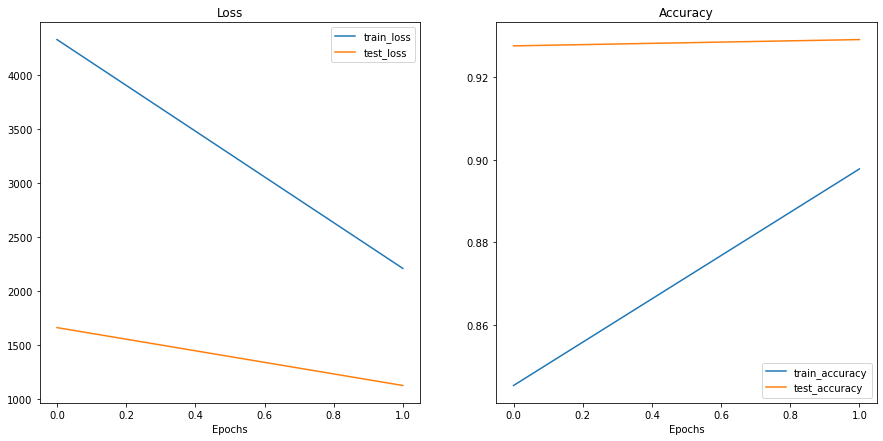

In [39]:
# Plot the loss curves of our model
plot_loss_curves(results)